In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPS import IPS
from AdaIPS_v2 import AdaIPS_S
from getData import getData

In [2]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.t_losses = []
        self.v_losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [3]:
epochs = 5
batch_size = 64


In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainloader, trainset, testloader, testset, validationloader, valset = getData('MNIST', transform=transform, batch_size=batch_size)

In [5]:
def train(model, optimizer, epochs=2):
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

    
            # if i % 100 == 0:                
            #     with torch.no_grad():
            #         for v_i, (v_inputs, v_labels) in enumerate(validationloader):
            #             v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
            #             v_outputs = model(v_inputs)
            #             v_loss = criterion(v_outputs, v_labels)
                    
            #         print("validation loss", v_loss.item())                   
            #     model.v_losses.append(v_loss.item())
                
            loss = optimizer.step(closure)
            
            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
                model.t_losses.append(loss.item())
            

    print("Training complete.")
    return model

In [6]:
def test(model):
    for i, (inputs, labels) in enumerate(testloader):
        output = model(inputs)
        output = output.argmax(axis=1)
        print(accuracy_score(labels, output.detach().numpy()))

In [7]:
adaIpsModel = SimpleNN().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters(), T=epochs * (len(trainset)/batch_size), lower_bound=0, beta_1=0.9, beta_2=0.99)
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

initialized optimizer with per layer learning rate: False
AdaIPS_S (
Parameter Group 0
    T0: 3750.0
    beta_1: 0.9
    beta_2: 0.99
    eps: 1e-08
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.2919414043426514
Epoch 1, Step 100, Loss: 0.5416254997253418
Epoch 1, Step 200, Loss: 0.4317317605018616
Epoch 1, Step 300, Loss: 0.21273574233055115
Epoch 1, Step 400, Loss: 0.24786359071731567
Epoch 1, Step 500, Loss: 0.22498171031475067
Epoch 1, Step 600, Loss: 0.13236504793167114
Epoch 1, Step 700, Loss: 0.2950630486011505
Epoch 2, Step 0, Loss: 0.13351483643054962
Epoch 2, Step 100, Loss: 0.0520176999270916
Epoch 2, Step 200, Loss: 0.18500474095344543
Epoch 2, Step 300, Loss: 0.23372705280780792
Epoch 2, Step 400, Loss: 0.06947633624076843
Epoch 2, Step 500, Loss: 0.047553807497024536
Epoch 2, Step 600, Loss: 0.04166513308882713
Epoch 2, Step 700, Loss: 0.14156115055084229
Epoch 3, Step 0, Loss: 0.11117403954267502
Epoch 3, Step 100, Loss: 0.13372309505939484
Epoch 3, Step 200, Loss: 0.16

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [8]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * (len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=5)

IPS (
Parameter Group 0
    T: 3750.0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.320735216140747
Epoch 1, Step 100, Loss: 0.7954726815223694
Epoch 1, Step 200, Loss: 0.578148365020752
Epoch 1, Step 300, Loss: 0.4610910713672638
Epoch 1, Step 400, Loss: 0.46962761878967285
Epoch 1, Step 500, Loss: 0.7608000040054321
Epoch 1, Step 600, Loss: 0.3130689859390259
Epoch 1, Step 700, Loss: 0.5125047564506531
Epoch 2, Step 0, Loss: 0.32796791195869446
Epoch 2, Step 100, Loss: 0.47182172536849976
Epoch 2, Step 200, Loss: 0.42351070046424866
Epoch 2, Step 300, Loss: 0.47122472524642944
Epoch 2, Step 400, Loss: 0.36687710881233215
Epoch 2, Step 500, Loss: 0.3700045347213745
Epoch 2, Step 600, Loss: 0.3135266900062561
Epoch 2, Step 700, Loss: 0.44903334975242615
Epoch 3, Step 0, Loss: 0.33299118280410767
Epoch 3, Step 100, Loss: 0.31250330805778503
Epoch 3, Step 200, Loss: 0.33499789237976074
Epoch 3, Step 300, Loss: 0.3633982539176941
Epoch 3, Step 400, Loss: 0.3863557279109955
Epoch 3, Step 5

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=5)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3140223026275635
Epoch 1, Step 100, Loss: 0.6040621995925903


In [ ]:
test(adaIpsModel)
test(ipsModel)
test(adamModel)

0.9725
0.9186
0.9731
0.9489


40
40
12
40


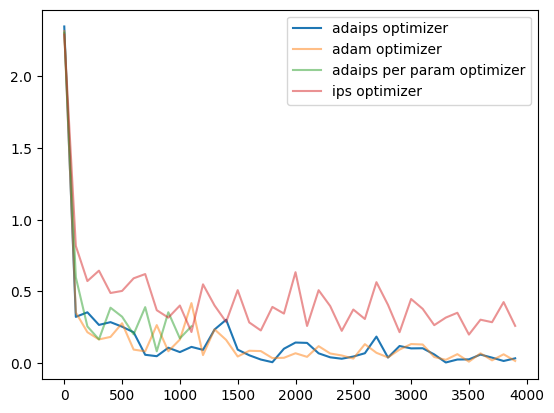

In [ ]:

models = [
    (adaIpsModel, 'adaips optimizer'),
    (adamModel, 'adam optimizer'),
    
    (ipsModel, 'ips optimizer')

]
exclude = []
focus = [adaIpsModel]
interval = 1
for model, optimizer in models:
    if model in exclude: continue
    print(len(model.t_losses))
    plt.plot(
        [i * 100 for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        label=optimizer,
        alpha=0.5 if model not in focus else 1
    )

plt.legend()
plt.show()

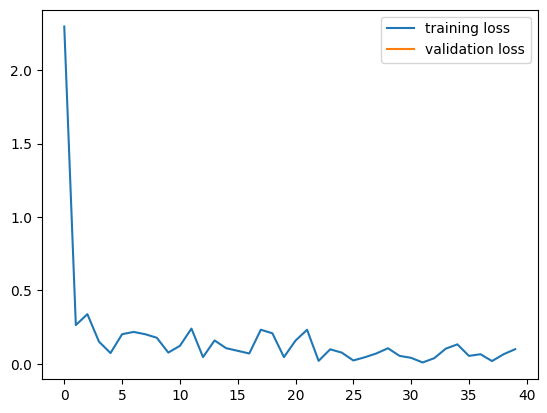

In [ ]:

plt.plot([t for t in adaIpsModel.t_losses], label='training loss')
plt.plot([v for v in adaIpsModel.v_losses], label='validation loss')
plt.legend()
plt.show()
